In [14]:
# Importing necessary libraries
import boto3
import sagemaker
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_store import FeatureStore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
import xgboost as xgb
from sagemaker.xgboost import XGBoostModel

In [2]:
# Initializing sagemaker session and clients
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
role = sagemaker.get_execution_role()
s3 = boto3.client("s3", region_name=region)
sagemaker_client = boto3.client("sagemaker", region_name=region)
featurestore_runtime = boto3.client("sagemaker-featurestore-runtime", region_name=region)

print(f"Using region: {region}")
print(f"SageMaker role: {role}")

Using region: us-east-1
SageMaker role: arn:aws:iam::851725636446:role/LabRole


In [3]:
# Retrieving data from feature store
def load_feature_group(fg_name, record_identifier="student_id", event_time="event_time"):
    fg = FeatureGroup(name=fg_name, sagemaker_session=sagemaker_session)

    query = fg.athena_query()
    table = query.table_name

    # Running SQL query to get all data from the feature group
    sql = f'SELECT * FROM "{table}"'
    print(f"Running query for Feature Group: {fg_name}")
    query.run(query_string=sql, output_location=f"s3://{sagemaker_session.default_bucket()}/athena-results/")
    query.wait()

    # Loading results into pandas
    df = query.as_dataframe()

    # Dropping duplicates by keeping latest event_time per student_id
    df = df.sort_values(by=[record_identifier, event_time]).drop_duplicates(subset=[record_identifier], keep="last")

    return df


def clean_featurestore_df(df):
    drop_cols = ["write_time", "is_deleted", "api_invocation_time", "event_time"]
    return df.drop(columns=[c for c in drop_cols if c in df.columns])


# Loading each feature group
demo_ses_df = load_feature_group("student-demographics-ses-fg")
performance_df = load_feature_group("student-performance-fg")
wellbeing_df = load_feature_group("student-wellbeing-fg")
target_df = load_feature_group("student-anxiety-target-fg")

print("\nFeature Group shapes:")
print(f"Demographics & SES: {demo_ses_df.shape}")
print(f"Academic Performance: {performance_df.shape}")
print(f"Student Wellbeing: {wellbeing_df.shape}")
print(f"Anxiety Target: {target_df.shape}")

# Cleaning dataset by dropping metadata columns before merging
demo_ses_df = clean_featurestore_df(demo_ses_df)
performance_df = clean_featurestore_df(performance_df)
wellbeing_df = clean_featurestore_df(wellbeing_df)
target_df = clean_featurestore_df(target_df)

# Joining into single dataset on "student_id"
df_merged = (
    demo_ses_df
    .merge(performance_df, on="student_id", how="inner")
    .merge(wellbeing_df, on="student_id", how="inner")
    .merge(target_df, on="student_id", how="inner")
)

print(f"\nFinal merged dataset shape: {df_merged.shape}")
df_merged.head()

Running query for Feature Group: student-demographics-ses-fg
Running query for Feature Group: student-performance-fg
Running query for Feature Group: student-wellbeing-fg
Running query for Feature Group: student-anxiety-target-fg

Feature Group shapes:
Demographics & SES: (32293, 11)
Academic Performance: (36824, 6)
Student Wellbeing: (25141, 13)
Anxiety Target: (35565, 6)

Final merged dataset shape: (25112, 17)


,student_id,age,grade,st004d01t,escs,homepos,wealth,academic_performance_index,belong,unfairteacher,scieeff,disclisci,motivat,pared,teachsup,emosups,anxiety_level_encoded
0,3600001.0,16.00,0.0,Male,1.3515,1.8051,2.6171,5.537787,2.5915,6.0,1.2229,0.3363,0.1111,15.0,1.4475,1.0991,1
1,3600002.0,15.83,0.0,Male,1.1971,0.9351,0.9759,5.921402,-1.0536,18.0,1.2067,0.6000,1.8543,15.0,-1.1047,0.0250,2
2,3600004.0,16.17,0.0,Female,1.2256,1.2377,1.0320,-2.584935,0.4153,7.0,-0.0176,-0.3506,0.5952,15.0,0.9209,1.0991,2
3,3600005.0,15.92,0.0,Male,0.8642,1.9803,1.4158,-0.075928,0.2947,19.0,0.3000,-1.1864,-0.4982,12.0,-0.2651,-0.2495,0
4,3600006.0,15.92,0.0,Male,0.3490,-0.0850,0.3716,-3.949186,-1.4204,21.0,3.2775,0.0039,1.8543,14.0,-2.7195,1.0991,2


In [4]:
# Converting all object/string columns to categorical codes for use with XGBoost
for col in df_merged.select_dtypes(include='object').columns:
    df_merged[col] = df_merged[col].fillna('missing').astype('category').cat.codes

# Verifying all columns are now numeric or category
print(df_merged.dtypes[df_merged.dtypes == 'object'])  # Should be empty

Series([], dtype: object)


In [5]:
# Splitting data into train, test, validation, and production sets

# Production split
df_trainvaltest, df_prod = train_test_split(
    df_merged, test_size=0.4, random_state=0, shuffle=True, stratify=df_merged["anxiety_level_encoded"]
)

# Splitting remaining data into train val and test sets
df_train, df_temp = train_test_split(
    df_trainvaltest, test_size=0.3333, random_state=0, shuffle=True, stratify=df_trainvaltest["anxiety_level_encoded"]
)

df_val, df_test = train_test_split(
    df_temp, test_size=0.5, random_state=0, shuffle=True, stratify=df_temp["anxiety_level_encoded"]
)

print("Dataset sizes:")
print(f"Train: {len(df_train)} ({len(df_train)/len(df_merged):.1%})")
print(f"Validation: {len(df_val)} ({len(df_val)/len(df_merged):.1%})")
print(f"Test: {len(df_test)} ({len(df_test)/len(df_merged):.1%})")
print(f"Production: {len(df_prod)} ({len(df_prod)/len(df_merged):.1%})")

Dataset sizes:
Train: 10045 (40.0%)
Validation: 2511 (10.0%)
Test: 2511 (10.0%)
Production: 10045 (40.0%)


In [6]:
# Separating features and target for each split and preprocessing
exclude_cols = ["student_id", "anxiety_level_encoded"]

x_train = df_train.drop(columns=exclude_cols)
y_train = df_train["anxiety_level_encoded"]

x_val = df_val.drop(columns=exclude_cols)
y_val = df_val["anxiety_level_encoded"]

x_test = df_test.drop(columns=exclude_cols)
y_test = df_test["anxiety_level_encoded"]

x_prod = df_prod.drop(columns=exclude_cols)
y_prod = df_prod["anxiety_level_encoded"]

# Standardizing numeric features
numeric_cols = x_train.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
x_train[numeric_cols] = scaler.fit_transform(x_train[numeric_cols])
x_val[numeric_cols] = scaler.transform(x_val[numeric_cols])
x_test[numeric_cols] = scaler.transform(x_test[numeric_cols])
x_prod[numeric_cols] = scaler.transform(x_prod[numeric_cols])

print("Feature matrices shapes:")
print(f"X_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {x_test.shape}, y_test: {y_test.shape}")
print(f"X_prod: {x_prod.shape}, y_prod: {y_prod.shape}")

Feature matrices shapes:
X_train: (10045, 15), y_train: (10045,)
X_val: (2511, 15), y_val: (2511,)
X_test: (2511, 15), y_test: (2511,)
X_prod: (10045, 15), y_prod: (10045,)


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:39:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.52      0.55      0.53       820
           1       0.52      0.54      0.53       848
           2       0.40      0.37      0.38       843

    accuracy                           0.49      2511
   macro avg       0.48      0.49      0.48      2511
weighted avg       0.48      0.49      0.48      2511

Test Set Metrics:
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       821
           1       0.54      0.57      0.56       847
           2       0.42      0.39      0.40       843

    accuracy                           0.50      2511
   macro avg       0.49      0.50      0.50      2511
weighted avg       0.49      0.50      0.50      2511



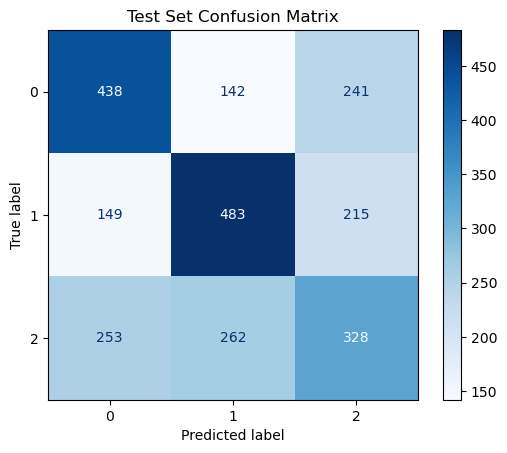

In [12]:
# Creating simple XGBoost classifier for baseline model
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y_train.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=0,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# Training model
xgb_clf.fit(
    x_train, y_train,
    eval_set=[(x_val, y_val)],
    verbose=False
)

# Making predictions on validation and test sets
y_val_pred = xgb_clf.predict(x_val)
y_test_pred = xgb_clf.predict(x_test)

# Evaluating baseline model
print("Validation Set Metrics:")
print(classification_report(y_val, y_val_pred))

print("Test Set Metrics:")
print(classification_report(y_test, y_test_pred))

# Printing confusion matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Set Confusion Matrix")
plt.show()

In [15]:
# Refining model

# Parameters for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 400],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_lambda': [1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5]
}

xgb_cv = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y_train.unique()),
    eval_metric='mlogloss',
    enable_categorical=True,
    random_state=0
)

random_search = RandomizedSearchCV(
    xgb_cv,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

random_search.fit(x_train, y_train)
print("Best parameters found:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [ ]:
# Combining training and validation sets for final model training
x_full_train = pd.concat([x_train, x_val])
y_full_train = pd.concat([y_train, y_val])

best_params = random_search.best_params_

xgb_best = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(y_train.unique()),
    eval_metric='mlogloss',
    enable_categorical=True,
    random_state=0,
    **best_params
)

xgb_best.fit(
    x_full_train, y_full_train,
    verbose=False
)

# Evaluating model
y_val_pred = xgb_refined.predict(x_val)
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred))

# Test predictions
y_test_pred = xgb_refined.predict(x_test)
print("Test Metrics:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Test Set Confusion Matrix")
plt.show()

# Feature importance
xgb.plot_importance(xgb_refined, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Top 20 Feature Importances")
plt.show()